In [86]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math, time
import itertools
from sklearn import preprocessing
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM

In [87]:
feanum=6
window=5
df2=pd.read_excel('guozhai.xlsx',2)
df1=df2.iloc[:,1:]
df1.tail()

,f1,f2,f3,f4,f5,rate
166,2.546471,-2.681992,3.360717,3.2,8.0,3.337368
167,2.728571,-2.495202,8.500000,-0.9,8.6,3.306371
168,2.727727,-2.307692,5.400000,-0.1,8.5,3.235242
169,2.607143,-2.497598,5.000000,0.2,8.5,3.168083
170,2.507368,-2.687140,6.300000,-0.3,8.5,3.046959


In [88]:
rate_origin=df1['rate']

In [89]:
df=(df1-df1.min())/(df1.max()-df1.min())
df.tail()

,f1,f2,f3,f4,f5,rate
166,0.273278,0.211665,0.195790,0.654867,0.000000,0.345916
167,0.304329,0.224819,0.355742,0.292035,0.027599,0.329365
168,0.304185,0.238023,0.259259,0.362832,0.022999,0.291386
169,0.283624,0.224650,0.246810,0.389381,0.022999,0.255527
170,0.266611,0.211302,0.287270,0.345133,0.022999,0.190854


In [90]:
#加载keras模块
from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

import keras
from keras.utils import np_utils
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

In [91]:
def load_data(stock, seq_len):#输入data表格
    amount_of_features = len(stock.columns)#有几列
    data = stock.as_matrix() #pd.DataFrame(stock) 讲表格转化为矩阵
    sequence_length = seq_len + 1#序列长度5+1
    result = []
    for index in range(len(data) - sequence_length):#循环170-5次
        result.append(data[index: index + sequence_length])#第i行到i+5行

    result = np.array(result)#得到161个样本，样本形式为6天*3特征
    row = round(0.9 * result.shape[0])#划分训练集测试集
    train = result[:int(row), :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]
#reshape成 5天*3特征
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]


In [92]:
def build_model2(layers):
        d = 0.1
        model = Sequential()
        model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
        model.add(Dropout(d))
        model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
        model.add(Dropout(d))
        model.add(Dense(16,init='uniform',activation='relu'))        
        model.add(Dense(1,init='uniform',activation='relu'))
        model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
        return model

In [93]:
X_train, y_train, X_test, y_test = load_data(df, window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (148, 5, 6)
y_train (148,)
X_test (17, 5, 6)
y_test (17,)


E:\anoconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [94]:
# model = build_model([3,lag,1])
model = build_model2([feanum,window,1])

E:\anoconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="uniform")`
  
E:\anoconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':


In [95]:
history = LossHistory()

In [96]:
model.fit(
    X_train,
    y_train,
    batch_size=80,
    nb_epoch=1000,
    validation_split=0.1,
    verbose=0,
    callbacks=[history])

E:\anoconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:8: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


在测试集和验证集上的loss/acc下降情况


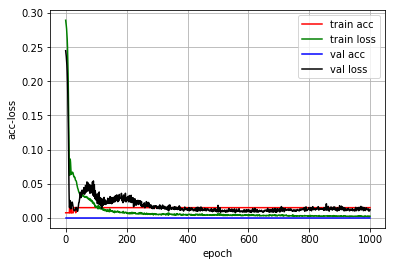

In [97]:
print('在测试集和验证集上的loss/acc下降情况')
history.loss_plot('epoch')

In [98]:
print('在测试集和训练集上的误差（均方误差MSE/均方根误差RMSE）:')
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

在测试集和训练集上的误差（均方误差MSE/均方根误差RMSE）:
Train Score: 0.00 MSE (0.05 RMSE)
Test Score: 0.02 MSE (0.15 RMSE)


在训练集上的表现:


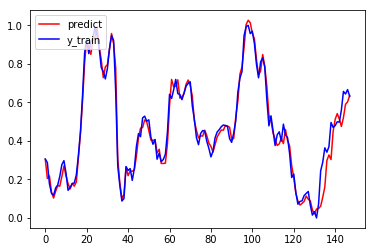

In [99]:
import matplotlib.pyplot as plt2

plt2.plot(model.predict(X_train),color='red', label='predict')
plt2.plot(y_train,color='blue', label='y_train')
plt2.legend(loc='upper left')
print('在训练集上的表现:')
plt2.show()

在测试集上的表现


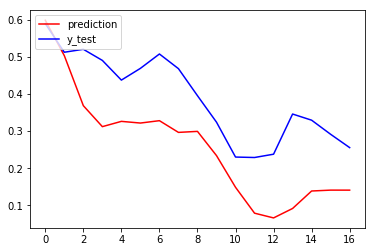

In [100]:
p=model.predict(X_test)
plt2.plot(p,color='red', label='prediction')
plt2.plot(y_test,color='blue', label='y_test')
plt2.legend(loc='upper left')
print('在测试集上的表现')
plt2.show()


In [101]:
y_predict=p
y_var_test=y_test[1:]-y_test[:len(y_test)-1]
y_var_predict=y_predict[1:]-y_predict[:len(y_predict)-1]
txt=np.zeros(len(y_var_test))
for i in range(len(y_var_test-1)):
    txt[i]=np.sign(y_var_test[i])==np.sign(y_var_predict[i])
result=sum(txt)/len(txt)
print('胜率（预测涨跌正确）:',result)

胜率（预测涨跌正确）: 0.5625


In [102]:
print('已经保存预测数据在文件predict_value.csv中')
predata=p[:,0]
out=predata*(rate_origin.max()-rate_origin.min())+rate_origin.min()
df = pd.DataFrame(out)
df.to_csv('predict_value.csv')

已经保存预测数据在文件predict_value.csv中
